In [65]:
import astropy.units as u
import h5py
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import Distance, SkyCoord
from astropy.io import fits
from dustmaps import sfd
from tqdm.auto import tqdm

plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["figure.figsize"] = (11, 7)

In [133]:
# fmt: off

f = h5py.File("/st/datasets/gdr3_astronn_xp_coeffs_full.h5", "r")

data_apogee = fits.open("/st/datasets/apogee_astroNN-DR17.fits")[1].data

cols = ["ra","dec","TEFF","TEFF_ERR","LOGG","LOGG_ERR","C_H","C_H_ERR","CI_H","CI_H_ERR","N_H","N_H_ERR","O_H","O_H_ERR","NA_H","NA_H_ERR","MG_H","MG_H_ERR","AL_H","AL_H_ERR","SI_H","SI_H_ERR","P_H","P_H_ERR","S_H","S_H_ERR","K_H","K_H_ERR","CA_H","CA_H_ERR","TI_H","TI_H_ERR","TIII_H","TIII_H_ERR","V_H","V_H_ERR","CR_H","CR_H_ERR","MN_H","MN_H_ERR","FE_H","FE_H_ERR","CO_H","CO_H_ERR","NI_H","NI_H_ERR","age","age_total_error",]
_data = {key: data_apogee[key].astype("float32") for key in cols}
_data["source_id"] = data_apogee["source_id"].astype("int64")
df_apogee = (
    pd.DataFrame(_data)
    .dropna(
        subset=["ra","dec","TEFF","TEFF_ERR","LOGG","LOGG_ERR","MG_H","MG_H_ERR","FE_H","FE_H_ERR","age","age_total_error",]
    )
    .drop_duplicates(subset="source_id")
)

In [68]:
matches, idx_apogee_full, idx_xp_full = np.intersect1d(
    df_apogee["source_id"], f["ids"][:], return_indices=True
)
df_apogee = df_apogee.iloc[idx_apogee_full]

In [17]:
rdp = h5py.File("/st/datasets/radecplx.h5", "r")

In [69]:
match, idx1, idx2 = np.intersect1d(
    df_apogee["source_id"].to_numpy(), rdp["source_id"][:], return_indices=True
)
df_apogee = df_apogee.iloc[idx1]
df_apogee["parallax"] = rdp["parallax"][:][idx2]
df_apogee["parallax_error"] = rdp["parallax_error"][:][idx2]

In [71]:
sfdquery = sfd.SFDQuery()
ebv = sfdquery.query(
    SkyCoord(
        ra=df_apogee["ra"] * u.deg,
        dec=df_apogee["dec"] * u.deg,
    )
)
df_apogee["sfd_ebv"] = ebv

In [126]:
mask = np.logical_and.reduce(
    (
        df_apogee["parallax"] > 0,
        # df_apogee["parallax"] / df_apogee["parallax_error"] > 5.0,
        # df_apogee["age_total_error"] / df_apogee["age"] < 0.3,
        # df_apogee["LOGG"] < 3.5,
        # df_apogee["LOGG_ERR"] < 0.12,
        # df_apogee["sfd_ebv"] < 0.1,
        df_apogee["FE_H"] > -5.0,
    )
)
mask.sum()

531853

In [127]:
coords = SkyCoord(
    ra=df_apogee["ra"][mask] * u.deg,
    dec=df_apogee["dec"][mask] * u.deg,
    distance=Distance(parallax=df_apogee["parallax"][mask].to_numpy() * u.mas),
)
gc = coords.galactocentric

Text(0, 0.5, 'Z')

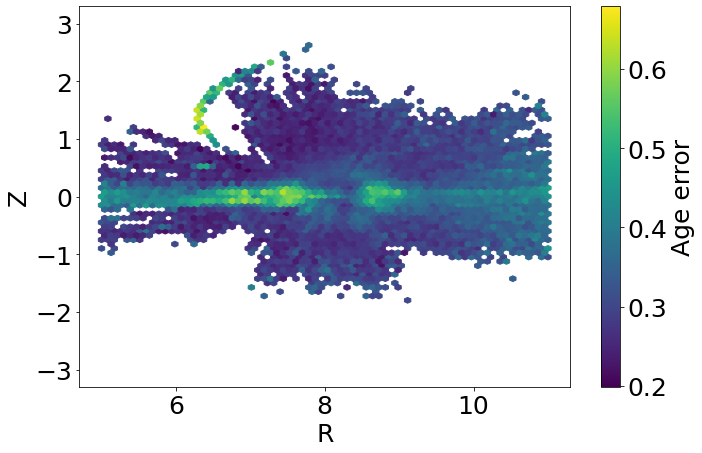

In [132]:
plt.hexbin(
    np.sqrt(gc.x**2 + gc.y**2).to(u.kpc),
    gc.z.to(u.kpc),
    # gc.x.to(u.kpc),
    # gc.y.to(u.kpc),
    C=df_apogee["age_total_error"][mask] / df_apogee["age"][mask],
    mincnt=20,
    gridsize=70,
    extent=[5, 11, -3, 3],
    # norm=matplotlib.colors.LogNorm(),
)
plt.colorbar(label="Age error")
plt.xlabel("R")
plt.ylabel("Z")

Text(0, 0.5, 'Age error (%)')

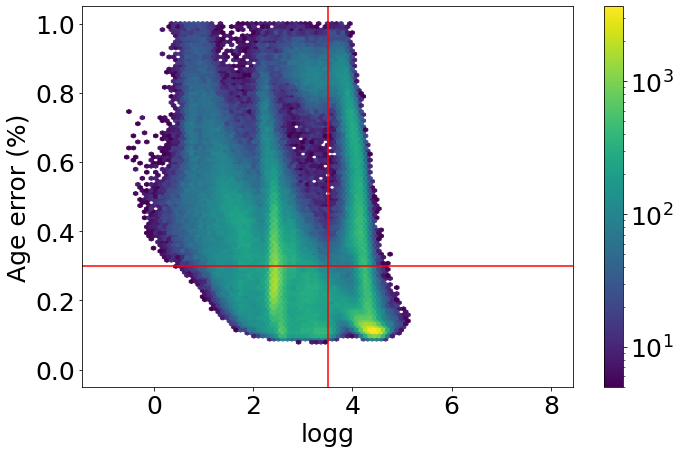

In [125]:
plt.hexbin(
    df_apogee["LOGG"],
    df_apogee["age_total_error"] / df_apogee["age"],
    extent=[-1, 8, 0, 1],
    mincnt=5,
    norm=matplotlib.colors.LogNorm(),
)
plt.axhline(0.3, c="r")
plt.axvline(3.5, c="r")
plt.colorbar()
plt.xlabel("logg")
plt.ylabel("Age error (%)")